## Observations and Insights 

In [18]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as st
import numpy as np

# Study data files
mouse_metadata_path = "data/Mouse_metadata.csv"
study_results_path = "data/Study_results.csv"

# Read the mouse data and the study results
mouse_metadata = pd.read_csv(mouse_metadata_path)
study_results = pd.read_csv(study_results_path)

# Combine the data into a single dataset
MouseMerge= pd.merge(mouse_metadata, study_results, on="Mouse ID", how="outer")
# Display the data table for preview
MouseMerge

#MouseOutput = MouseMerge.to_csv("MouseMerge.csv", index=False)

,Mouse ID,Drug Regimen,Sex,Age_months,Weight (g),Timepoint,Tumor Volume (mm3),Metastatic Sites
0,k403,Ramicane,Male,21,16,0,45.000000,0
1,k403,Ramicane,Male,21,16,5,38.825898,0
2,k403,Ramicane,Male,21,16,10,35.014271,1
3,k403,Ramicane,Male,21,16,15,34.223992,1
4,k403,Ramicane,Male,21,16,20,32.997729,1
...,...,...,...,...,...,...,...,...
1888,z969,Naftisol,Male,9,30,25,63.145652,2
1889,z969,Naftisol,Male,9,30,30,65.841013,3
1890,z969,Naftisol,Male,9,30,35,69.176246,4
1891,z969,Naftisol,Male,9,30,40,70.314904,4


In [19]:
# Checking the number of mice.
Mice = MouseMerge["Mouse ID"].nunique()
print("There are " + str(Mice) + " total mice enrolled in the study.")

There are 249 total mice enrolled in the study.


In [20]:
# # Getting the duplicate mice by ID number that shows up for Mouse ID and Timepoint. 
# ID = MouseMerge["Mouse ID"]
MouseMerge['Dupe'] = MouseMerge.duplicated(subset = ["Mouse ID", "Timepoint"],keep=False)
Dupes = MouseMerge.loc[MouseMerge['Dupe'] == True]
DupeMice = Dupes.groupby(["Mouse ID"]).count()
DupeMice

,Drug Regimen,Sex,Age_months,Weight (g),Timepoint,Tumor Volume (mm3),Metastatic Sites,Dupe
Mouse ID,,,,,,,,
g989,10,10,10,10,10,10,10,10


In [21]:
# Optional: Get all the data for the duplicate mouse ID. 
BadMouse = MouseMerge.loc[MouseMerge['Mouse ID'] == "g989"]
BadMouse

,Mouse ID,Drug Regimen,Sex,Age_months,Weight (g),Timepoint,Tumor Volume (mm3),Metastatic Sites,Dupe
908,g989,Propriva,Female,21,26,0,45.000000,0,True
909,g989,Propriva,Female,21,26,0,45.000000,0,True
910,g989,Propriva,Female,21,26,5,48.786801,0,True
911,g989,Propriva,Female,21,26,5,47.570392,0,True
912,g989,Propriva,Female,21,26,10,51.745156,0,True
913,g989,Propriva,Female,21,26,10,49.880528,0,True
914,g989,Propriva,Female,21,26,15,51.325852,1,True
915,g989,Propriva,Female,21,26,15,53.442020,0,True
916,g989,Propriva,Female,21,26,20,55.326122,1,True
917,g989,Propriva,Female,21,26,20,54.657650,1,True


In [22]:
# Create a clean DataFrame by dropping the duplicate mouse by its ID.
MiceIndices = MouseMerge[MouseMerge["Mouse ID"] == "g989"].index
MiceIndices
CleanMice = MouseMerge.copy()
CleanMice.drop(MiceIndices, inplace = True)

CleanMice

,Mouse ID,Drug Regimen,Sex,Age_months,Weight (g),Timepoint,Tumor Volume (mm3),Metastatic Sites,Dupe
0,k403,Ramicane,Male,21,16,0,45.000000,0,False
1,k403,Ramicane,Male,21,16,5,38.825898,0,False
2,k403,Ramicane,Male,21,16,10,35.014271,1,False
3,k403,Ramicane,Male,21,16,15,34.223992,1,False
4,k403,Ramicane,Male,21,16,20,32.997729,1,False
...,...,...,...,...,...,...,...,...,...
1888,z969,Naftisol,Male,9,30,25,63.145652,2,False
1889,z969,Naftisol,Male,9,30,30,65.841013,3,False
1890,z969,Naftisol,Male,9,30,35,69.176246,4,False
1891,z969,Naftisol,Male,9,30,40,70.314904,4,False


In [23]:
# Checking the number of mice in the clean DataFrame.
Clean = CleanMice["Mouse ID"].nunique()
Bad = BadMouse["Mouse ID"].nunique ()

print("There are " + str(Clean) + " mice left in the study after " + str(Bad) + " mouse was removed.")

There are 248 mice left in the study after 1 mouse was removed.


## Summary Statistics

In [24]:
# Generate a summary statistics table of mean, median, variance, standard deviation, and SEM of the tumor volume for each regimen

# Use groupby and summary statistical methods to calculate the following properties of each drug regimen: 
# mean, median, variance, standard deviation, and SEM of the tumor volume. 
# Assemble the resulting series into a single summary dataframe.
Summary = pd.DataFrame(round(CleanMice.groupby(['Drug Regimen'])["Tumor Volume (mm3)"].mean(),2))
Summary.rename(columns={"Tumor Volume (mm3)":"Mean"}, inplace=True)

SumMed = round(CleanMice.groupby(['Drug Regimen'])["Tumor Volume (mm3)"].median(),2)
Summary["Median"] = SumMed

SumVar = round(CleanMice.groupby(['Drug Regimen'])["Tumor Volume (mm3)"].var(),2)
Summary["Var"] = SumVar

SumSTD = round(CleanMice.groupby(['Drug Regimen'])["Tumor Volume (mm3)"].std(),2)
Summary["STD"] = SumSTD

SumSEM = round(CleanMice.groupby(['Drug Regimen'])["Tumor Volume (mm3)"].sem(),2)
Summary["SEM"] = SumSEM

Summary

,Mean,Median,Var,STD,SEM
Drug Regimen,,,,,
Capomulin,40.68,41.56,24.95,4.99,0.33
Ceftamin,52.59,51.78,39.29,6.27,0.47
Infubinol,52.88,51.82,43.13,6.57,0.49
Ketapril,55.24,53.70,68.55,8.28,0.60
Naftisol,54.33,52.51,66.17,8.13,0.60
Placebo,54.03,52.29,61.17,7.82,0.58
Propriva,52.32,50.45,43.85,6.62,0.54
Ramicane,40.22,40.67,23.49,4.85,0.32
Stelasyn,54.23,52.43,59.45,7.71,0.57


In [25]:
# Generate a summary statistics table of mean, median, variance, standard deviation, and SEM of the tumor volume for each regimen

# Using the aggregation method, produce the same summary statistics in a single line
ShortSum = round(CleanMice.groupby(['Drug Regimen']).agg({"Tumor Volume (mm3)":['mean', "median", "var", "std","sem"]}),2)

ShortSum                                                      

Tumor Volume (mm3)                          
                           mean median    var   std   sem
Drug Regimen                                             
Capomulin                 40.68  41.56  24.95  4.99  0.33
Ceftamin                  52.59  51.78  39.29  6.27  0.47
Infubinol                 52.88  51.82  43.13  6.57  0.49
Ketapril                  55.24  53.70  68.55  8.28  0.60
Naftisol                  54.33  52.51  66.17  8.13  0.60
Placebo                   54.03  52.29  61.17  7.82  0.58
Propriva                  52.32  50.45  43.85  6.62  0.54
Ramicane                  40.22  40.67  23.49  4.85  0.32
Stelasyn                  54.23  52.43  59.45  7.71  0.57
Zoniferol                 53.24  51.82  48.53  6.97  0.52

## Bar and Pie Charts

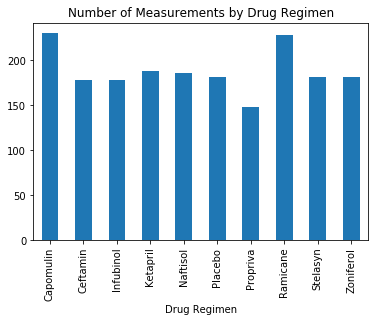

In [30]:
# Generate a bar plot showing the total number of measurements taken on each drug regimen using pandas.
MeasurementCount = CleanMice.groupby(["Drug Regimen"]).count()
MeasurementCount.drop(["Sex", "Age_months", "Weight (g)", "Timepoint", "Tumor Volume (mm3)", "Metastatic Sites", "Dupe"],axis = 1, inplace = True)
MeasurementCount
MeasurementCount.plot(kind="bar", title = "Number of Measurements by Drug Regimen", legend = False)


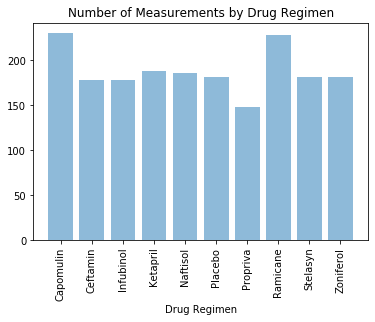

In [35]:
# Generate a bar plot showing the total number of measurements taken on each drug regimen using pyplot.
x_axis = np.arange(len(MeasurementCount))
tick_locations = [value+0.4 for value in x_axis]
plt.bar(x_axis, MeasurementCount["Mouse ID"], alpha=0.5, align="edge")
plt.xticks(tick_locations, MeasurementCount.index, rotation="vertical")
plt.title("Number of Measurements by Drug Regimen")
plt.xlabel("Drug Regimen")
plt.show()

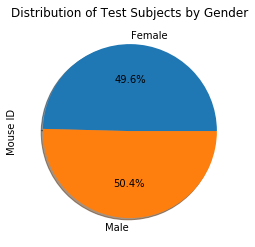

In [14]:
# Generate a pie plot showing the distribution of female versus male mice using pandas
MetadataIndices = mouse_metadata[mouse_metadata["Mouse ID"] == "g989"].index
MetadataIndices
CleanMetadata = mouse_metadata.copy()
CleanMetadata.drop(MetadataIndices, inplace = True)
MetaGroup = CleanMetadata.groupby(["Sex"]).count()
MetaGroup
MetaGroup.plot(kind = "pie", y = "Mouse ID", legend = False, title = "Distribution of Test Subjects by Gender", shadow = True, autopct = "%1.1f%%")

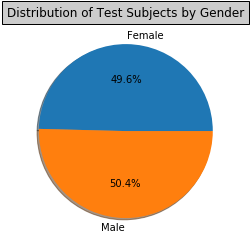

In [34]:
# Generate a pie plot showing the distribution of female versus male mice using pyplot
plt.pie(MetaGroup["Mouse ID"], autopct = "%1.1f%%", labels = MetaGroup.index , shadow = True)
plt.title("Distribution of Test Subjects by Gender", bbox={'facecolor':'0.8', 'pad':5})
plt.show()

## Quartiles, Outliers and Boxplots

In [ ]:
# Calculate the final tumor volume of each mouse across four of the treatment regimens:  
# Capomulin, Ramicane, Infubinol, and Ceftamin

# Start by getting the last (greatest) timepoint for each mouse


# Merge this group df with the original dataframe to get the tumor volume at the last timepoint


In [ ]:
# Put treatments into a list for for loop (and later for plot labels)


# Create empty list to fill with tumor vol data (for plotting)


# Calculate the IQR and quantitatively determine if there are any potential outliers. 

    
    # Locate the rows which contain mice on each drug and get the tumor volumes
    
    
    # add subset 
    
    
    # Determine outliers using upper and lower bounds
    

In [ ]:
# Generate a box plot of the final tumor volume of each mouse across four regimens of interest


## Line and Scatter Plots

In [ ]:
# Generate a line plot of tumor volume vs. time point for a mouse treated with Capomulin


In [ ]:
# Generate a scatter plot of average tumor volume vs. mouse weight for the Capomulin regimen


## Correlation and Regression

In [ ]:
# Calculate the correlation coefficient and linear regression model 
# for mouse weight and average tumor volume for the Capomulin regimen
